In [1]:
# Preface
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
import numpy as np
from os.path import isdir
from os import makedirs

from collections import OrderedDict

%config Completer.use_jedi = False

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sys import path as syspath
syspath.append("./functions/")

from physio_def_1 import getApparentFreq, importFrames, getTimes, rebin, plotImageWithRois

In [2]:
pathToFile = '//s2/physio/team/slakrupnik/project/experiments/Experiment30_no_lin_scan.lif'

In [3]:
md = bf.get_omexml_metadata(pathToFile)
xml = bf.OMEXML(md)
Nimages = xml.get_image_count()
rdr = bf.ImageReader(pathToFile, perform_init=True)
extension = "."+pathToFile.split(".")[-1]

In [4]:
iSeries = 7

im = xml.image(iSeries)
Name = im.Name
dimensions = dict(zip("TXY",(getattr(im.Pixels, "Size"+dim) for dim in "TXY")))

if dimensions["T"]>1:
    dimensions['freq'] = getApparentFreq(iSeries,xml)

In [5]:
dimensions

{'T': 7927, 'X': 512, 'Y': 512, 'freq': 1.981383098366963}

In [6]:
image = importFrames(rdr,idx=iSeries, which=(100,)).mean(axis=0)

In [7]:
from plotFirst_1 import plotImage

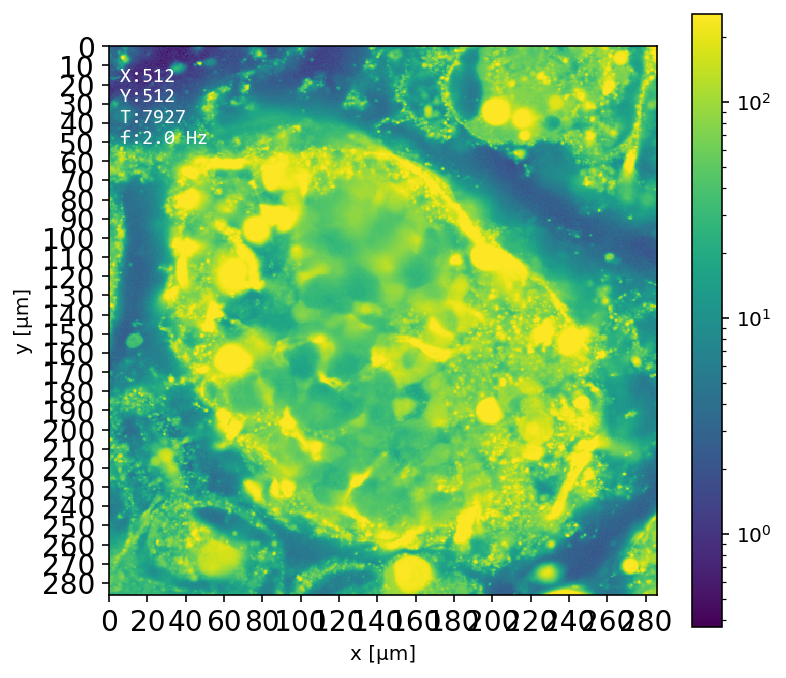

In [8]:
pxSize = im.Pixels.get_PhysicalSizeX()
pxUnit = im.Pixels.get_PhysicalSizeXUnit()

text = "\n".join([" %s:%i"%(c,dimensions[c])  for c in "XYT"])

if dimensions["T"]>1:
    text += "\n f:%.1f Hz"%dimensions['freq']

plotImage(image.T,pxSize=pxSize,pxUnit=pxUnit,
          rescale=1./50,
          #savePath=saveDir+outName,
          addInfo=text)
plt.tight_layout()

# Choose a patch to import all

In [41]:
%%time
subimage = importFrames(rdr,idx=iSeries,which=(dimensions["T"],(100,200),(100,200)))

Wall time: 2min 40s


In [42]:
time = getTimes(xml_=xml,idx_=iSeries)[:len(subimage)]

In [43]:
pxSize

0.5587442270058709

In [137]:
pxWin=10
pxShows = [(30+i*pxWin,j*pxWin) for i in range(6) for j in range(8)]

In [138]:
slowTimescale = 30 # in seconds
tWin=int(slowTimescale*dimensions["freq"])

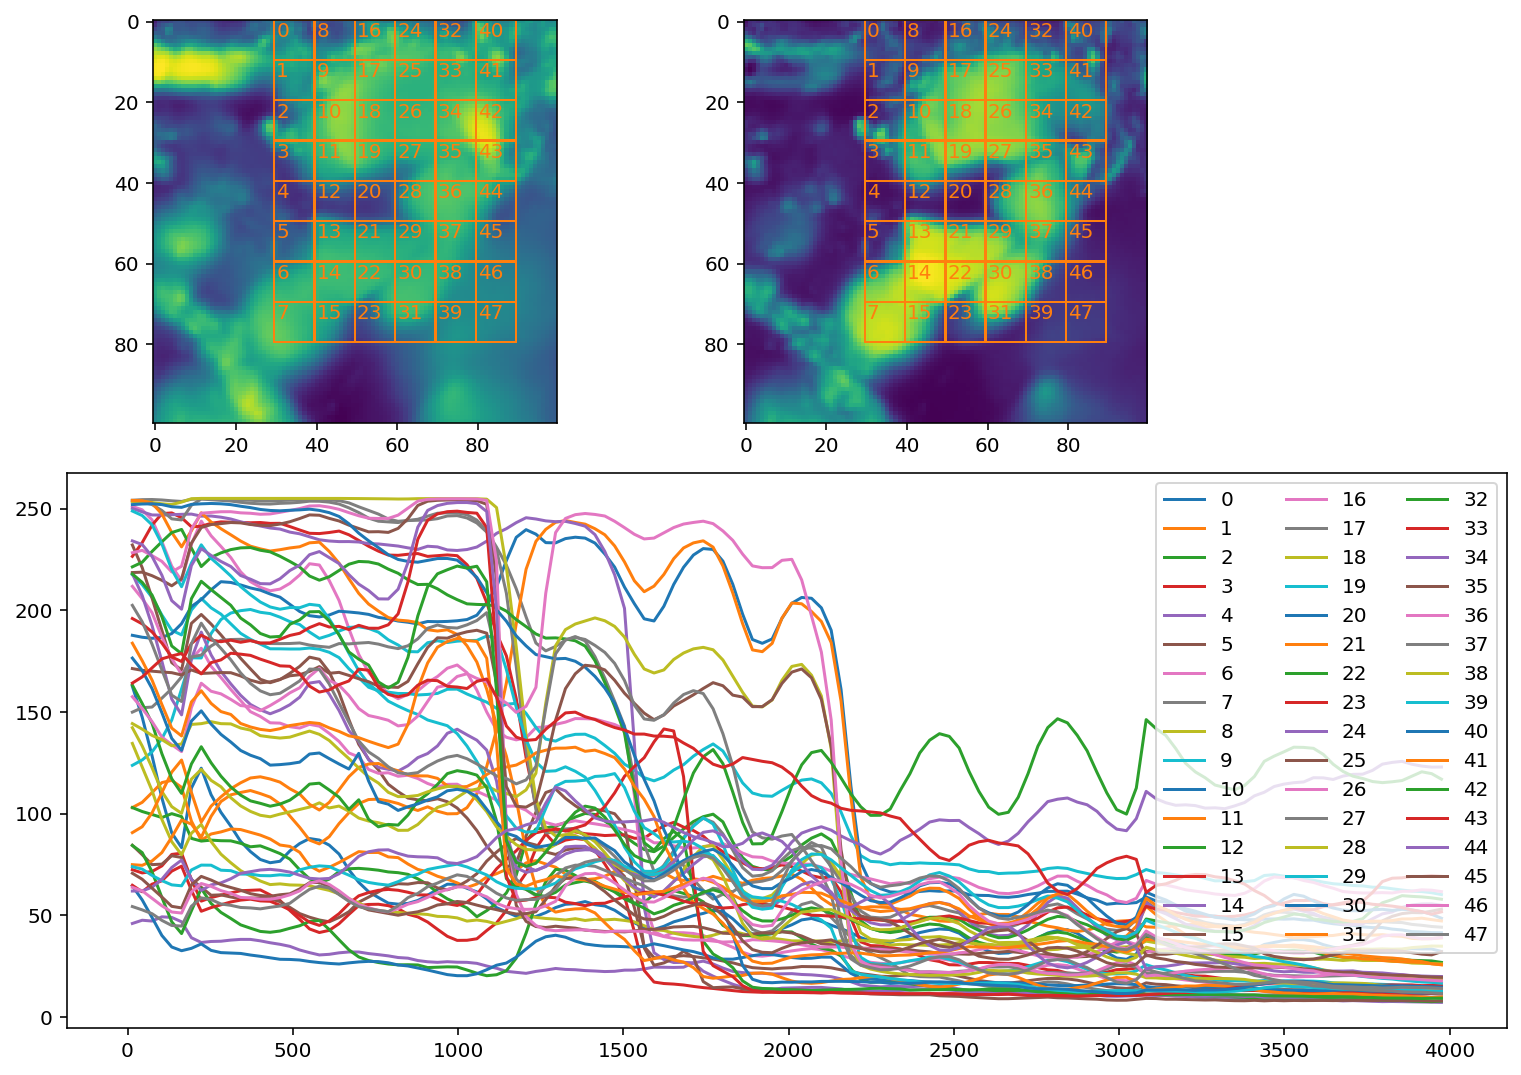

In [139]:
# fig, axs = plt.subplots(1,2,figsize=(10,3))
fig = plt.figure(figsize=(10,7))

axsUp = [
    fig.add_axes([0,.6,.4,.4]),
    fig.add_axes([.41,.6,.4,.4])
]
roiProfiles = plotImageWithRois(
            pxShows = pxShows,
            pxWin   = pxWin,
            image_=subimage[:,:,:],
            stdDev=True,
            axs =axsUp,
            label=True
        )[1];
ax = fig.add_axes([0,0,1,.55])
for roiLabel in roiProfiles:
    ax.plot(rebin(time,tWin),
            rebin(roiProfiles[roiLabel],tWin), label=roiLabel)

ax.legend(ncol=len(roiProfiles)//20+1)

In [140]:
X = np.vstack(list(roiProfiles.values()))
X = rebin(X,tWin,axis=1)
X.shape

(48, 134)

In [141]:
CorrCoefRaw = np.corrcoef(X)

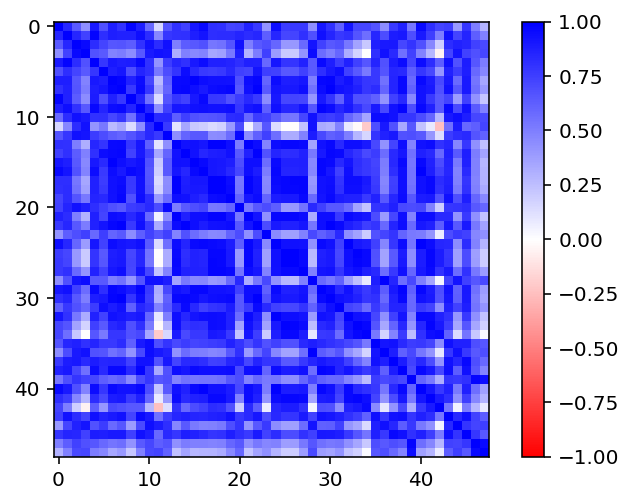

In [142]:
plt.imshow(CorrCoefRaw,vmin=-1,vmax=1,cmap="bwr_r")
plt.colorbar()

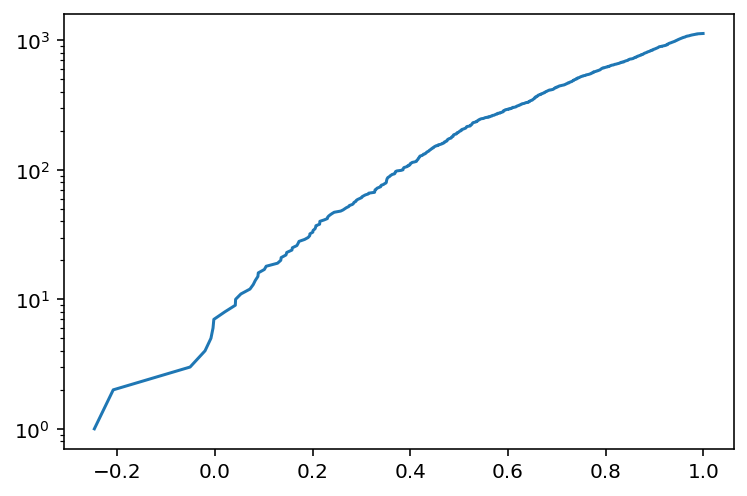

In [143]:
x = CorrCoefRaw[np.triu_indices_from(CorrCoefRaw,1)]
plt.plot(sorted(x),np.arange(len(x))+1)
plt.yscale("log")

# Choose some extremes to show

In [144]:
indices = np.triu_indices_from(CorrCoefRaw)
tmp = indices+(CorrCoefRaw[indices],)
tmp = list(zip(*tmp))

In [145]:
tmp = sorted(tmp,key=lambda xi: xi[-1])

In [146]:
interestinPairs = np.array(tmp)[:,:2].astype(int)

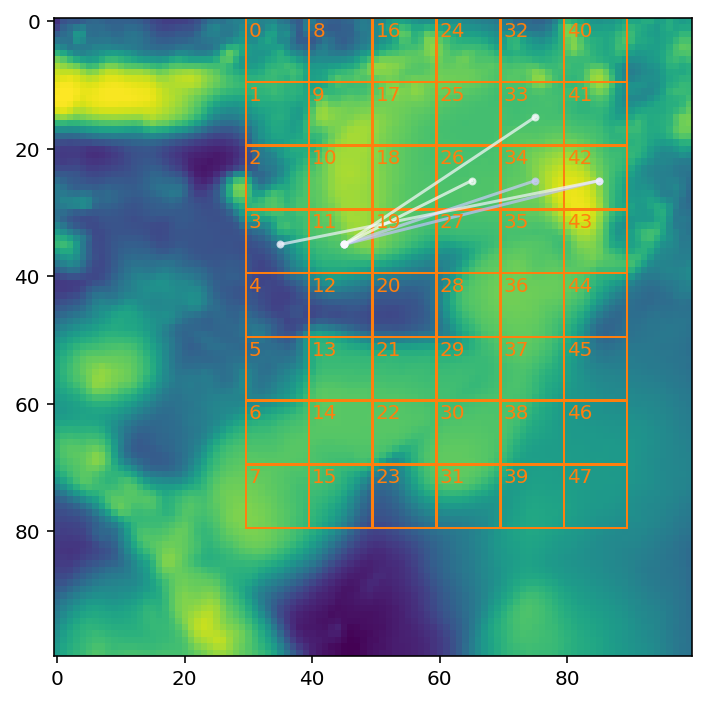

In [147]:
ax,roiProfiles = plotImageWithRois(pxShows,pxWin,image_=subimage*100,imgHeight=5);
for i,j in interestinPairs[:5]:
    if j<=i: continue
    v = CorrCoefRaw[i,j]
    x,y = np.array(pxShows[i])+pxWin/2,np.array(pxShows[j])+pxWin/2
    c = plt.cm.bwr((v+1)/2)
    plt.plot(*np.array([x,y]).T,marker=".",color=c,alpha = .7)
plt.tight_layout()
# plt.savefig("C:/Users/sarikass/Downloads/anticorr_representation.png",dpi=150)

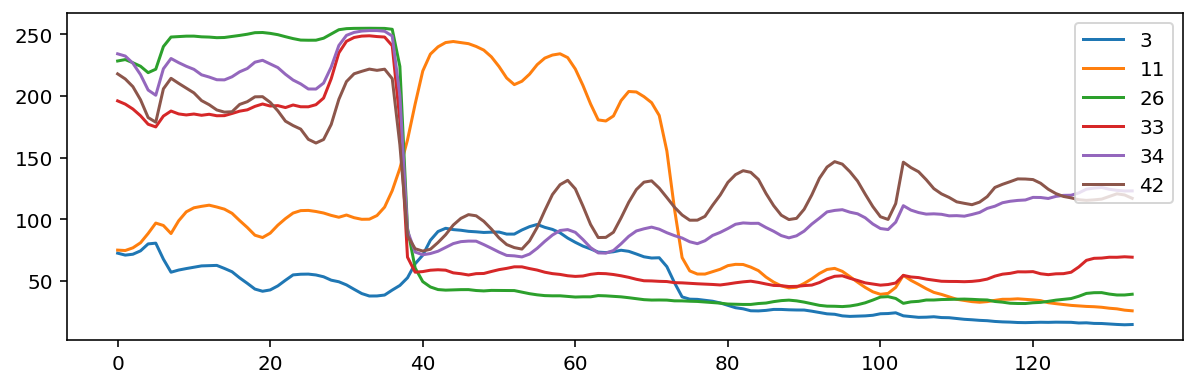

In [148]:
plt.figure(figsize=(10,3))
for roiLabel in np.unique(interestinPairs[:6]):
    plt.plot(X[roiLabel], label=roiLabel)
plt.legend()

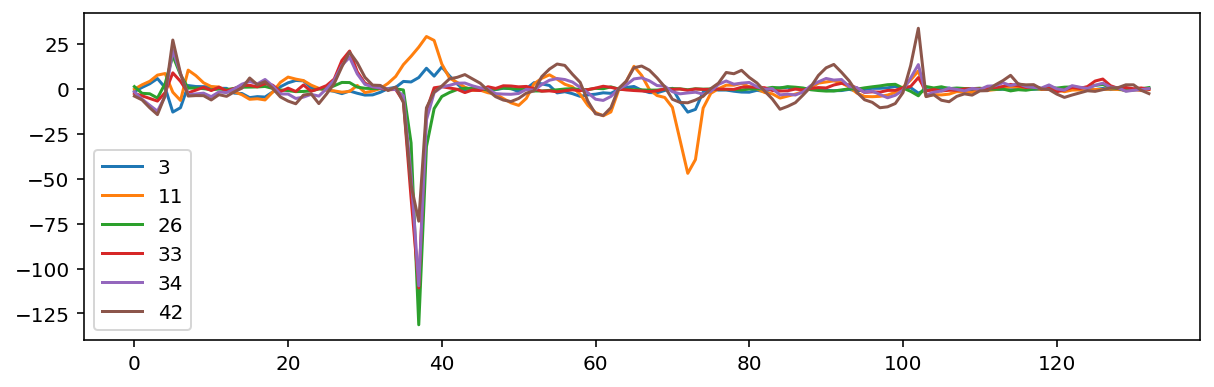

In [149]:
plt.figure(figsize=(10,3))
for roiLabel in np.unique(interestinPairs[:6]):
    plt.plot(np.diff(X[roiLabel]), label=roiLabel)
plt.legend()

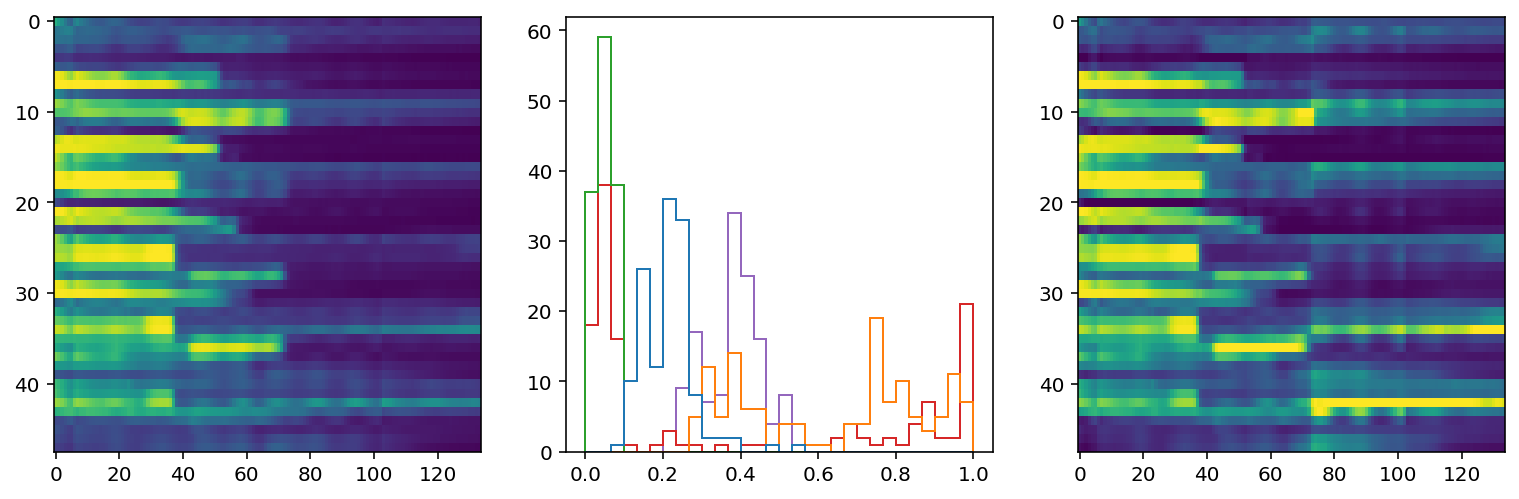

In [150]:
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()#RobustScaler()#Normalizer()#
ppX = mm_scaler.fit_transform(X)

plt.figure(figsize=(13,4))

plt.subplot(1,3,2)
plt.hist(ppX[::10,:].T, 30,histtype="step");#filled", alpha = .3);


plt.subplot(1,3,1)
plt.imshow(X)
plt.gca().set_aspect("auto")


plt.subplot(1,3,3)
plt.imshow(ppX)
plt.gca().set_aspect("auto")

# Try clusterning on correlation matrix

In [151]:
import scipy.cluster.hierarchy as spc

[]

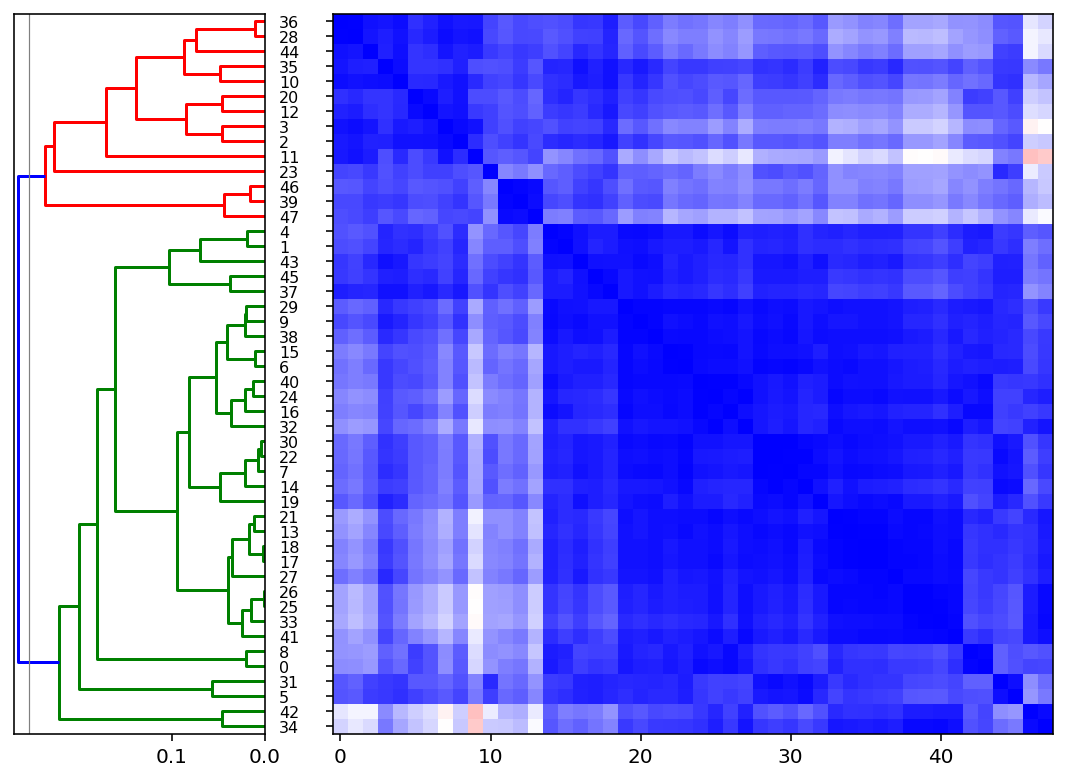

In [153]:
linkage = spc.linkage(X, method='average', metric='correlation')

scale = 10

threshold = .4
add = .3

fig = plt.figure(figsize=np.array([1.15+add,1])*5)

axDnd = fig.add_axes([0,0,add*.8,1])
Z = linkage.copy()
Z[:,-2] *= scale
dnd = spc.dendrogram(Z,color_threshold=threshold*scale,ax=axDnd, orientation="left");
axDnd.axvline(threshold*scale,color="grey",lw=.6)
axDnd.set_xscale("symlog")
xt = axDnd.get_xticks()
axDnd.set_xticklabels(xt/scale)

rightOrder = dnd["leaves"][::-1]
D = CorrCoefRaw[rightOrder]
D = D[:,rightOrder]

axCM  = fig.add_axes([add,0,1-add,1])#, sharey=axDnd)
axCM.imshow(D, vmin=-1,vmax=1,cmap="bwr_r")
axCM.set_yticks(range(len(D)))
axCM.set_yticklabels([])


# PCA

In [154]:
def myPCA(data):
    '''
    Input:  2D numpy array where rows are observations
    Output: a tuple Eigenvalues, Eigenvetors
    '''
    from scipy import linalg as la
    C = np.cov(data, rowvar=False)
    vals, vecs = la.eigh(C)
    vals = vals[::-1]
    vecs = vecs.T[::-1]
    datamean = data.mean(axis=0)
    for i in range(len(vals)):
        if datamean.dot(vecs[i])<0:
            vecs[i] = -vecs[i]
    return vals, vecs

In [155]:
def project(observation, vecs, obsmean = 0):
    return obsmean+np.sum([observation.dot(v)*v for v in vecs], axis=0)

In [156]:
import pandas as pd

In [157]:
vals, vecs = myPCA(ppX)

In [158]:
vecs.shape

(134, 134)

([<matplotlib.axis.XTick at 0x389a6160>,
 <a list of 6 Text xticklabel objects>)

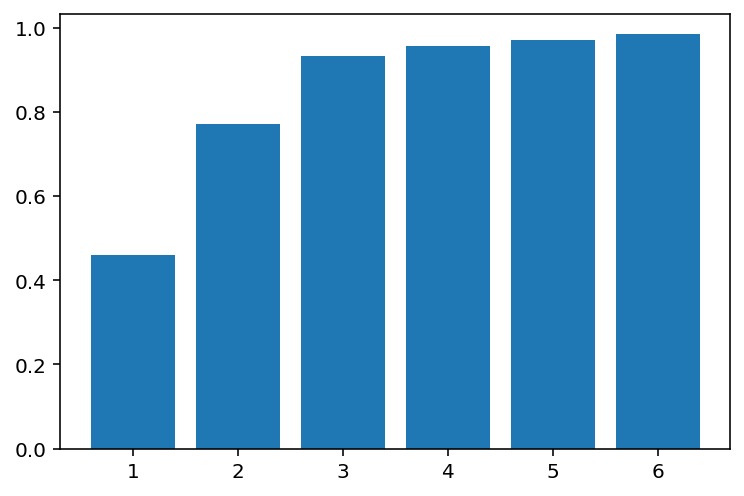

In [159]:
percVarExplained = np.cumsum(vals/sum(vals))
nComponents = np.where(percVarExplained<.99)[0][-1]
plt.bar(np.arange(nComponents)+1,percVarExplained[:nComponents])
plt.xticks(np.arange(nComponents)+1)

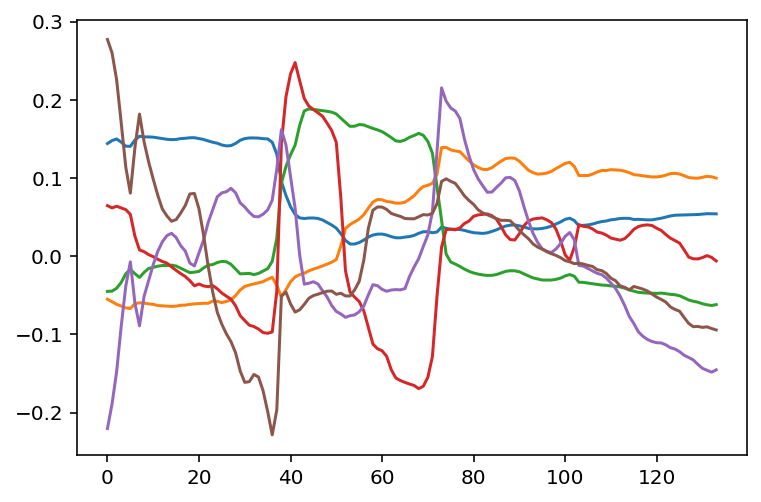

In [160]:
plt.plot(vecs[:nComponents,:].T)

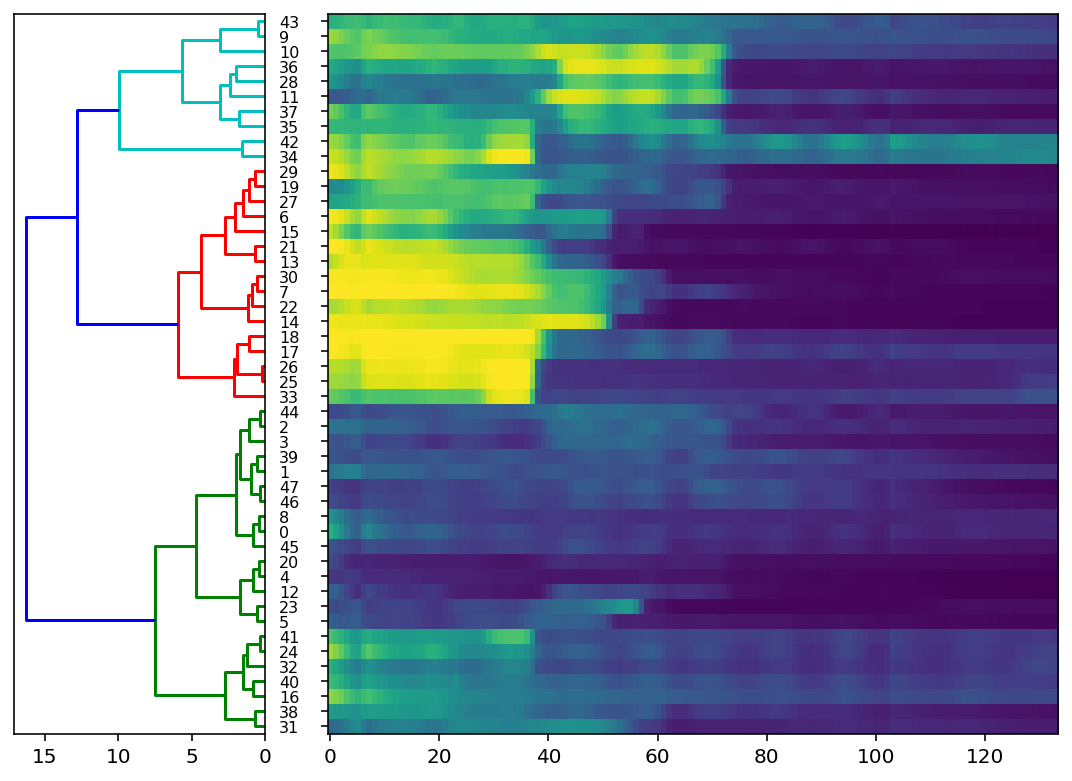

In [161]:
for nComponents in [4]:
    ppXproj = np.array([[t.dot(vecs[j]) for j in range(nComponents)] for t in ppX])
    linkage = spc.linkage(ppXproj, method='ward')
    add = .3
    fig = plt.figure(figsize=np.array([1.15+add,1])*5)
    axDnd = fig.add_axes([0,0,add*.8,1])
    dnd = spc.dendrogram(linkage,ax=axDnd, orientation="left");
    ax  = fig.add_axes([add,0,1-add,1])#, sharey=axDnd)
    rightOrder = dnd['leaves']
    ax.imshow(X[rightOrder],origin="bottom")
    ax.set_yticks(range(len(D)))
    ax.set_yticklabels([])
    # plt.xticks(range(len(rightOrder)), rightOrder);
    ax.set_aspect("auto")
    plt.show()

In [136]:
np.argmax(ppXproj.T[-1])

19

# Try hiding the transition periods

In [165]:
from scipy.signal import find_peaks

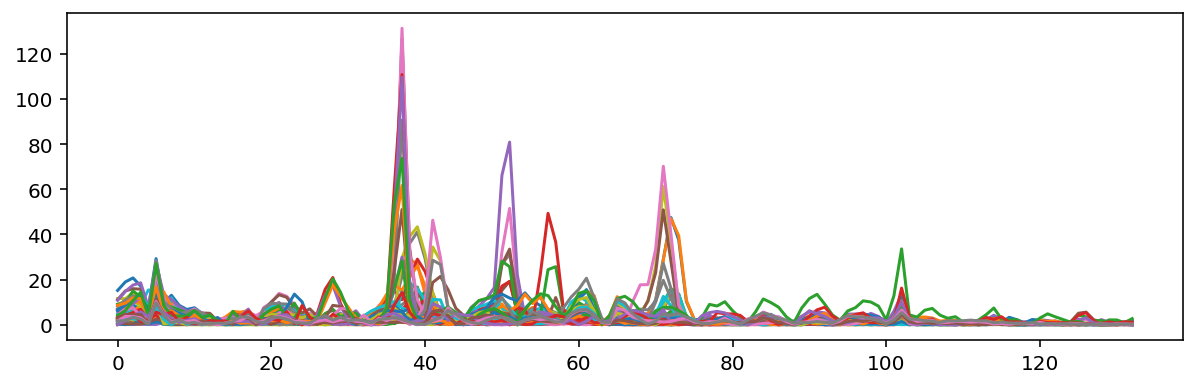

In [182]:
plt.figure(figsize=(10,3))
for roiLabel in np.unique(interestinPairs[:]):
    plt.plot(np.abs(np.diff(X[roiLabel])), label=roiLabel)

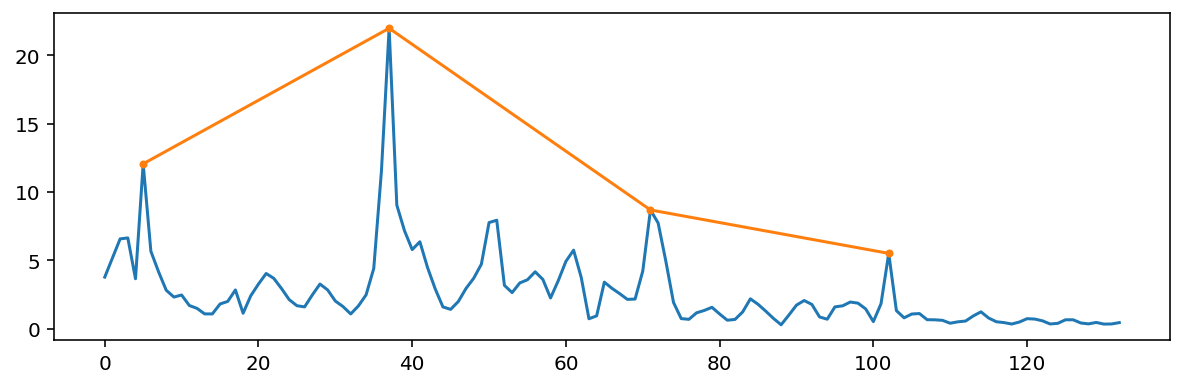

In [189]:
plt.figure(figsize=(10,3))
x = np.abs(np.diff(X,axis=1)).mean(0)
plt.plot(x)
transitions = find_peaks(x,width=1,prominence=3)[0][[0,1,4,5]]
plt.plot(transitions,x[transitions],".-")
transitions +=1

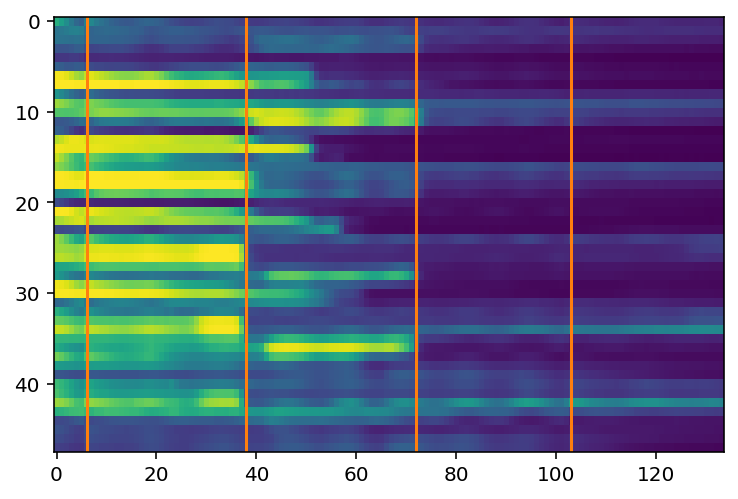

In [205]:
plt.imshow(X)
plt.gca().set_aspect('auto')
for i in transitions:
    plt.axvline(i,color="C1")

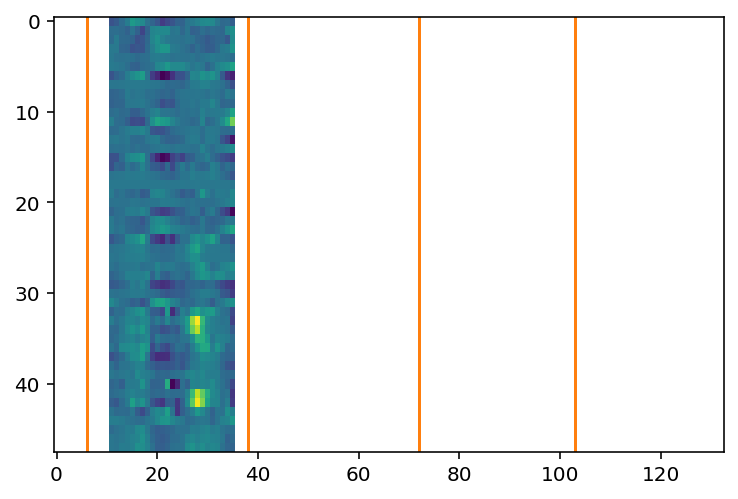

In [243]:
pm = 5
XX = X.copy()
XX = np.diff(XX,axis=1) #####
XX[:,:transitions[0]] = np.nan
for i in transitions:
    XX[:,i-pm//2:i+pm] = np.nan
XX[:,transitions[1]:] = np.nan
plt.imshow(XX)
plt.gca().set_aspect('auto')
for i in transitions:
    plt.axvline(i,color="C1")

In [244]:
XX = XX[:,~np.isnan(XX[0])]

In [245]:
ppXX = mm_scaler.fit_transform(XX)

In [246]:
vals, vecs = myPCA(ppXX)

In [247]:
vecs.shape

(25, 25)

([<matplotlib.axis.XTick at 0x3e9615f8>,
 <a list of 12 Text xticklabel objects>)

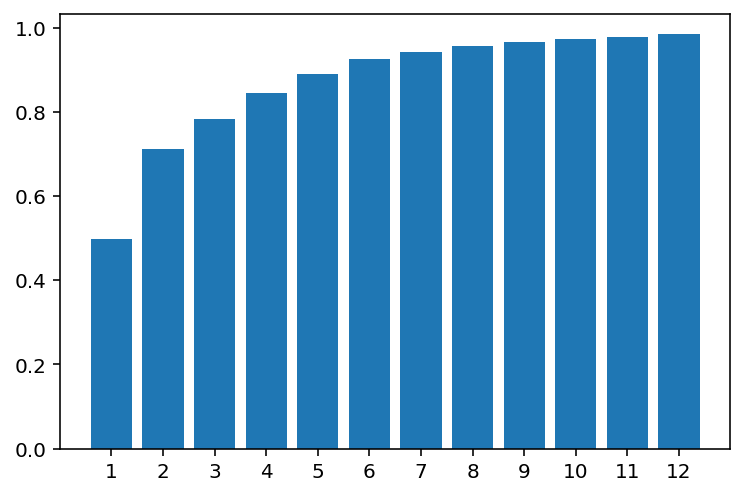

In [248]:
percVarExplained = np.cumsum(vals/sum(vals))
nComponents = np.where(percVarExplained<.99)[0][-1]
plt.bar(np.arange(nComponents)+1,percVarExplained[:nComponents])
plt.xticks(np.arange(nComponents)+1)

In [249]:
# plt.plot(vecs[:nComponents,:].T)

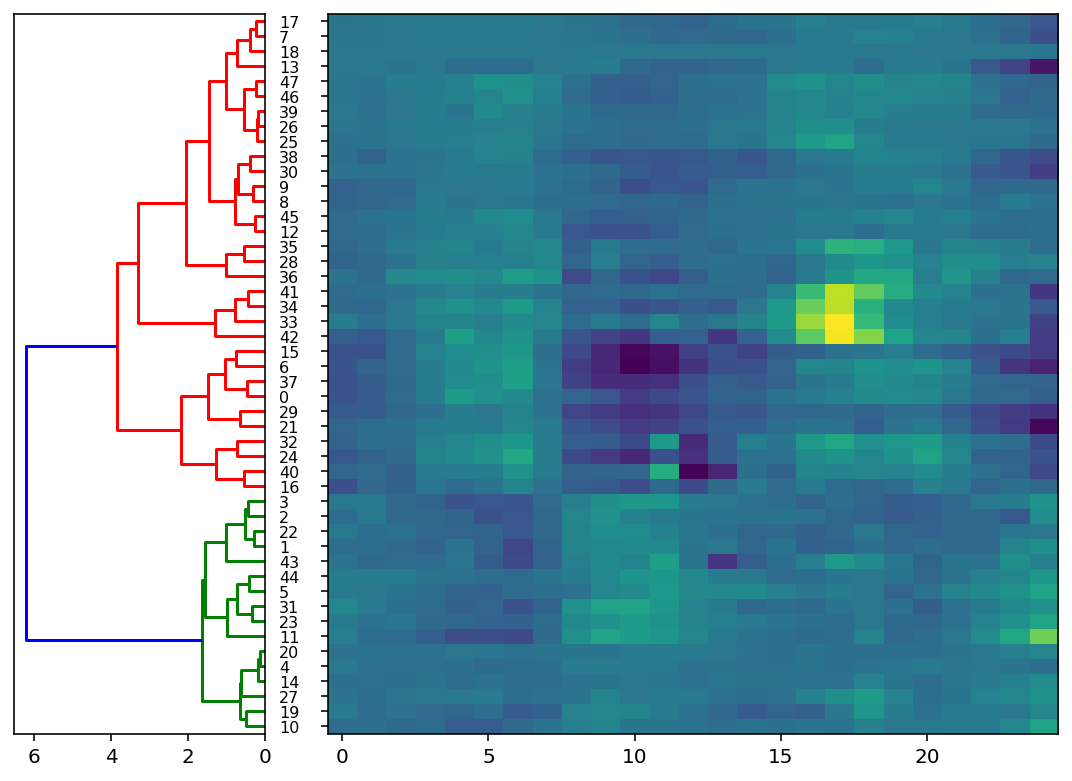

In [251]:
nComponents = 5
ppXproj = np.array([[t.dot(vecs[j]) for j in range(nComponents)] for t in ppXX])
linkage = spc.linkage(ppXproj, method='ward')
add = .3
fig = plt.figure(figsize=np.array([1.15+add,1])*5)
axDnd = fig.add_axes([0,0,add*.8,1])
dnd = spc.dendrogram(linkage,ax=axDnd, orientation="left");
ax  = fig.add_axes([add,0,1-add,1])#, sharey=axDnd)
rightOrder = dnd['leaves']
ax.imshow(XX[rightOrder],origin="bottom")
ax.set_yticks(range(len(D)))
ax.set_yticklabels([])
# plt.xticks(range(len(rightOrder)), rightOrder);
ax.set_aspect("auto")
plt.show()

# Remains

In [129]:
# pd.plotting.scatter_matrix(pd.DataFrame(ppXproj));

In [127]:
# linkage = spc.linkage(ppXproj, method='centroid')

# add = .3
# fig = plt.figure(figsize=np.array([1.15+add,1])*5)

# axDnd = fig.add_axes([0,0,add*.8,1])
# Z = linkage.copy()
# dnd = spc.dendrogram(linkage,ax=axDnd, orientation="left");
# # axDnd.axvline(threshold*scale,color="grey",lw=.6)
# # axDnd.set_xscale("symlog")
# # xt = axDnd.get_xticks()
# # axDnd.set_xticklabels(xt/scale)

# axCM  = fig.add_axes([add,0,1-add,1])#, sharey=axDnd)
# rightOrder = dnd['leaves'][::-1]
# D = C[rightOrder]
# D = D[:,rightOrder]
# axCM.imshow(D, vmin=-1,vmax=1,cmap="bwr_r")
# axCM.set_yticks(range(len(D)))
# axCM.set_yticklabels([])
# plt.xticks(range(len(rightOrder)), rightOrder);


In [128]:
# Ldf = pd.DataFrame(linkage,columns=["i","j","dist","count"])#dtype=["int","int","float","int"])
# for c in ["i","j","count"]:
#     Ldf[c] = Ldf[c].astype(int)

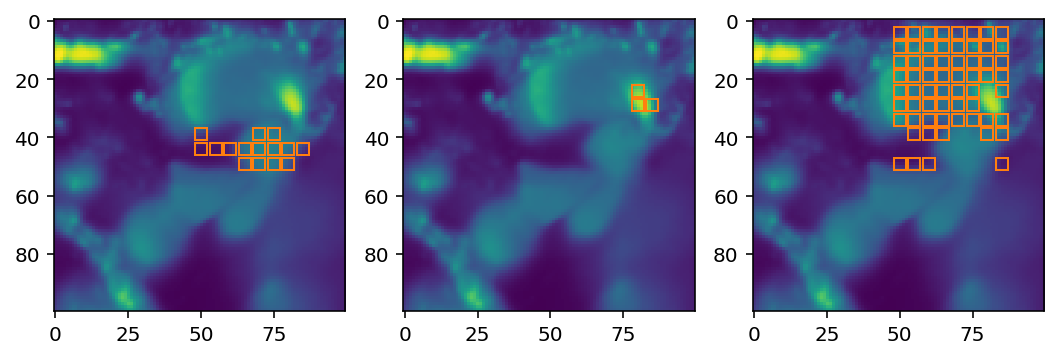

In [73]:
nc = 4
nr = int(np.ceil(len(np.unique(idx))/nc))
plt.figure(figsize=np.array([nc,nr,])*3)
for i in np.unique(idx):
    ax = plt.subplot(nr,nc,i)
    ax.imshow(subimage.mean(0).T)
    for x,y in np.array(pxShows)[idx==i]:
        plt.plot(x,y,"s",c="C1",mfc="none")
#     break

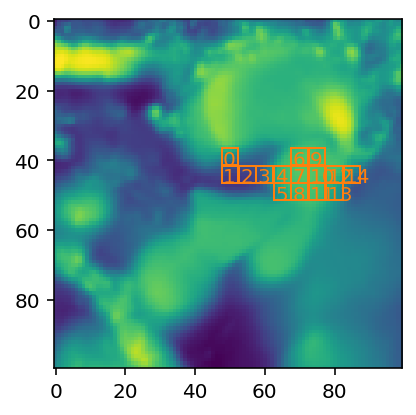

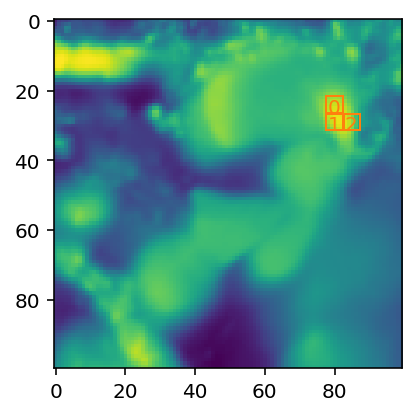

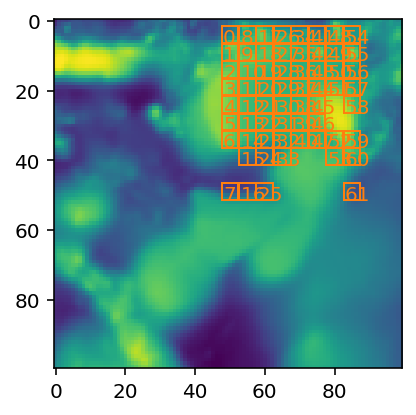

In [74]:
for i in np.unique(idx):
    plotRoisOnImage(np.array(pxShows)[idx==i],pxWin,image_=subimage,imgHeight=3)

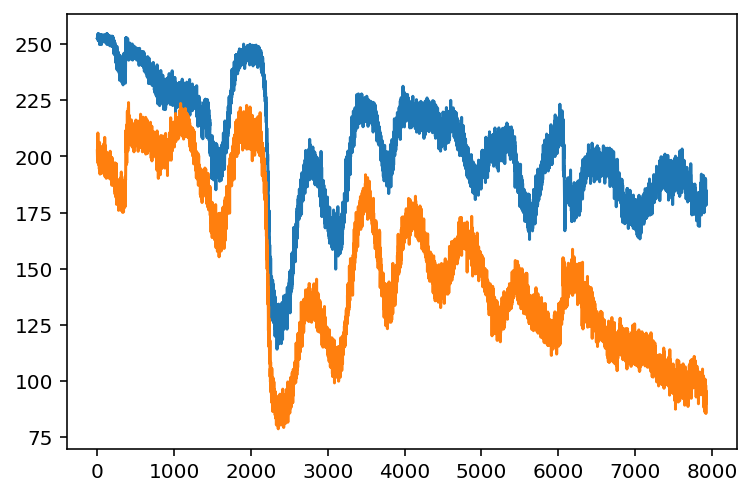

In [52]:
plt.plot(roiProfiles[65])
plt.plot(roiProfiles[75])

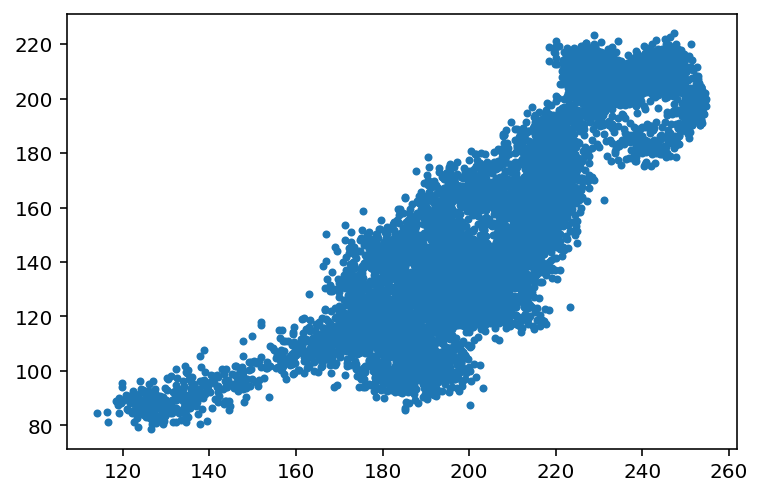

In [53]:
plt.plot(roiProfiles[65],roiProfiles[75],".")

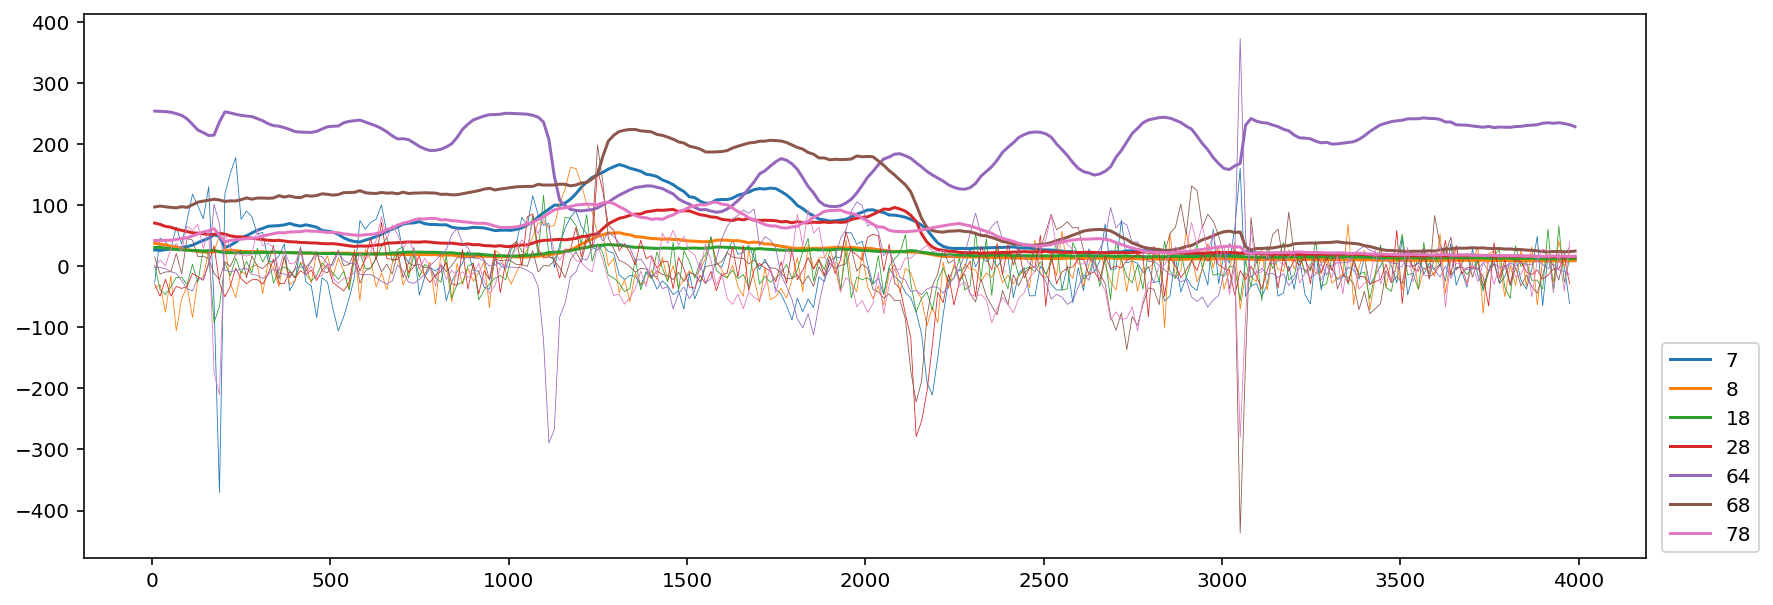

In [397]:
# %matplotlib notebook
# %matplotlib notebook

plt.figure(figsize=(14,5))
for j in np.unique(np.where(C<-.55)):
    tWin = 30
    t = rebin(time,tWin)
    x = rebin(roiProfiles[j],tWin)
    c = plt.plot(t,x,label=j)[0].get_color()
    plt.plot(t[:-1],np.diff(x)/x[:-1]*1000,c=c,lw=.4)
    
plt.legend(loc=(1.01,.01))

SyntaxError: invalid syntax (<ipython-input-373-937a9d8f3aee>, line 1)